In [9]:
import matplotlib.pyplot as plt

import numpy as np

import json
import glob
import sys
import os

# repo_root = os.path.abspath("..")
# if repo_root not in sys.path:
sys.path.insert(0, os.path.abspath(".."))


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from dataload import dataload_five_flower
from utils import train_engin
import classic_models
from tqdm import tqdm


import torch
from torchvision import transforms
import os

input_model_path = "prein1k_kan"  # 训练好的模型权重文件路径,如果文件路径变更，可以在这里修改
parallel = True  # 特别注意：是否使用多GPU进行验证，如果使用单GPU，可以改成False
model_name = "kansformer1"  # 模型名称，可以根据需要更改为其他模型，比如kansformer_tiny等

# 数据在项目文件夹 data/BM_data 下（相对于 notebook 的上级目录）
data_path = os.path.abspath(os.path.join("..", "data", "BM_data"))
num_class = 32 # 分类个数，因为这里官方给的数据的分类（共计40类），然而其中部分为0数据，故而这里就只需要分32个类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 指定使用的GPU编号，可以自己改成0或其他
tensorboard_log_dir = os.path.join("../results/tensorboard",input_model_path) # tensorboard日志文件保存路径
model_path = os.path.join("../results/weights", input_model_path, "kansformer_flower.pth")  # 训练好的模型权重文件路径,如果文件路径变更，可以在这里修改

print(f"调用的数据集路径：{data_path}\n模型权重文件路径：{model_path}\n")

print("正在构建验证集数据加载器......")

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

# 注意：这里要用变量 data_path，而不是字符串 'data_path'
val_dataset = dataload_five_flower.Five_Flowers_Load(
    os.path.join(data_path, 'val'), transform=data_transform["val"])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=24, shuffle=False, pin_memory=True, num_workers=0, collate_fn=val_dataset.collate_fn)

model = classic_models.find_model_using_name(model_name, num_classes=num_class) # 构造模型结构，确保和训练的时候完全相同；
model = model.to(device)
if parallel:
    model = torch.nn.DataParallel(model) # 由于训练时的使用了多GPU，故而这里也使用多GPU加载模型权重，否则会报错；

checkpoint = torch.load(model_path, map_location=device)  # 加载训练好的权重文件

model.load_state_dict(checkpoint) # 将权重文件加载到模型结构中
model.eval() # 将模型设置为评估模式

print("已完成模型加载，可以进行验证集评估......")

调用的数据集路径：/home/suxin/SCKansformer-main/data/BM_data
模型权重文件路径：../results/weights/prein1k_kan/kansformer_flower.pth

正在构建验证集数据加载器......
18458 images were found in the dataset.
已完成模型加载，可以进行验证集评估......


In [11]:
# val_acc = train_engin.evaluate(model,val_loader,device) # 使用系统自带的准确率评估函数进行评估

# print(f"在验证集上的准确率为：{val_acc:.3f}%")

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

100%|██████████| 770/770 [04:46<00:00,  2.68it/s]


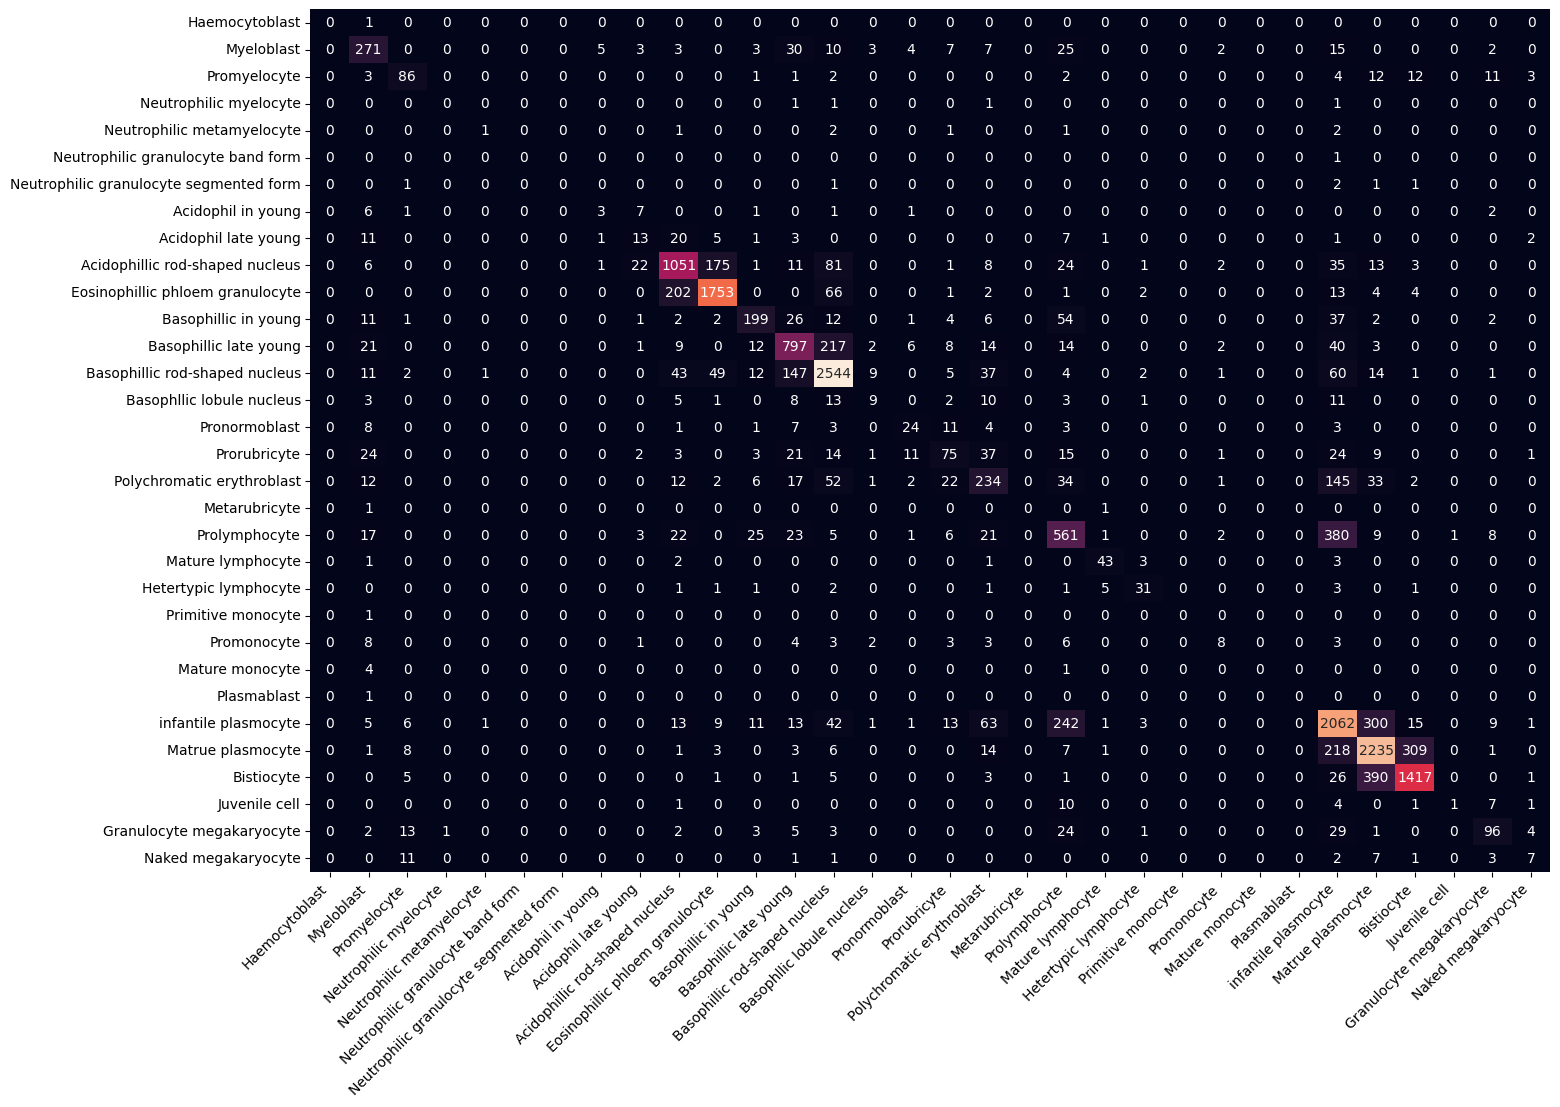

在验证集上的准确率为：73.253%


In [12]:
cm = confusion_matrix(all_labels, all_preds)
sns.reset_defaults()
n = cm.shape[0]
plt.gcf().set_size_inches(max(8, n*0.5), max(6, n*0.35)) # plt.gcf() 获取当前的 figure 对象，set_size_inches 设置图像大小，然后就是长、宽大小，这里用了max函数，最小8，最大依照数据数量输出
ax = sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=dataload_five_flower.data_name_dic,yticklabels=dataload_five_flower.data_name_dic) 
# heatmap 绘制热力图,数据选用cm即前面的confusion_matrix,annot=True表示在每个单元格上显示数据，fmt="d"表示数据格式为整数，cbar=False表示不显示热力图的颜色条，xticklabels和yticklabels分别设置x轴和y轴的标签

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.show()

sample_num = len(all_labels)
correct_num = np.sum(all_labels == all_preds)
accuracy = correct_num / sample_num * 100
print(f"在验证集上的准确率为：{accuracy:.3f}%")

In [13]:
from sklearn.metrics import recall_score, classification_report
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score


# # 假设你有以下数据
# # y_true: 真实标签 (形状 [n_samples,])
# # y_pred: 预测标签 (形状 [n_samples,])
# # 标签值从 0 到 31（对应 32 个类别）
# # 下面是Marco的数据以及调用官方的metrics函数显示

# y_true = all_labels
# y_pred = all_preds

# # 1. 计算每个类别的 Recall
# recall_per_class = recall_score(y_true, y_pred, average=None, labels=range(32))
# # recall_per_class 是一个包含 32 个值的数组

# # 2. 计算宏平均 Recall（推荐用于类别不平衡）
# macro_recall = recall_score(y_true, y_pred, average='macro')
# # 这等价于：np.mean(recall_per_class)

# # 3. 计算微平均 Recall
# micro_recall = recall_score(y_true, y_pred, average='micro')
# # 这等价于总体准确率：accuracy_score(y_true, y_pred)

# # 4. 计算加权平均 Recall
# weighted_recall = recall_score(y_true, y_pred, average='weighted')

# # 5. 获取完整报告（推荐！）
# report = classification_report(
#     y_true,
#     y_pred,
#     target_names=[f'Class_{i}' for i in range(32)],  # 你的类别名称
#     digits=4
# )
# print(report)
# # 报告会显示每个类别的 precision, recall, f1-score 和支持数（样本数）

Balanced Accuracy：68.221%;二分类的Accuracy:86.195%
Balanced Accuracy:37.38%
Kappa Score: 69.82%
MCC Score: 69.84%


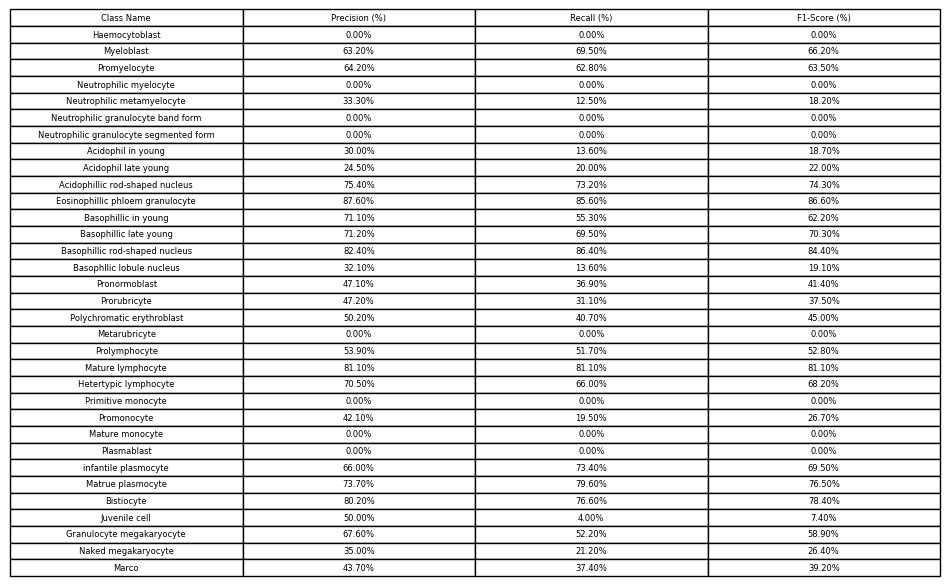

In [14]:
### Precision计算
def True_Positive(labels, preds, class_idx): # 返回预测为idx类，且真实为idx类的数量
    return np.sum((labels == class_idx) & (preds == class_idx))

def False_Positive(labels, preds, class_idx): # 返回预测为idx类，但真实不为idx类的数量
    return np.sum((labels != class_idx) & (preds == class_idx))

def False_Negative(labels, preds, class_idx): # 返回预测不为idx类，但真实为idx类的数量
    return np.sum((labels == class_idx) & (preds != class_idx))

def True_Negative(labels, preds, class_idx): # 返回预测不为idx类，且真实不为idx类的数量
    return np.sum((labels != class_idx) & (preds != class_idx))

TP = []
FP = []
Tab = np.empty((num_class+2, 4), dtype=object)  # 创建一个空的二维数组，用于存储混淆矩阵数据，第一列存储类别名称，第二列存储Precision，第三列存储存储Recall，第四列存储F1-Score
Tab[0,0] = 'Class Name'
Tab[0,1] = 'Precision (%)'
Tab[0,2] = 'Recall (%)'
Tab[0,3] = 'F1-Score (%)'
Tab[num_class+1,0] = 'Marco'
TP_sum = 0
TP_FN_sum = 0
FN_sum = 0
TN_sum = 0
FP_sum = 0
BA = 0.0
for idx in range(num_class):
    TP = True_Positive(all_labels, all_preds, idx) # 将正确的结果返回到TP这个list中，list只能用append方法添加数据
    FP = False_Positive(all_labels, all_preds, idx)
    FN = False_Negative(all_labels, all_preds, idx)
    TN = True_Negative(all_labels, all_preds, idx)
    BA += ((TP)/(TP+FN)+(TN)/(TN+FP))/2
    if TP + FP == 0:
        Tab[idx+1,1] = 0.0
    else:
        Tab[idx+1,1] = round((TP)/(TP+FP), 3)  # Precision

    if TP + FN == 0:
        Tab[idx+1,2] = 0.0
    else:
        Tab[idx+1,2] = round((TP)/(TP+FN),3)  # Recall

    if Tab[idx+1,1] + Tab[idx+1,2] == 0:
        Tab[idx+1,3] = 0.0
    else:
        Tab[idx+1,3] = round(2 * (Tab[idx+1,1] * Tab[idx+1,2]) / (Tab[idx+1,1] + Tab[idx+1,2]), 3)  # F1-Score
    TP_sum += TP
    FN_sum += FN
    TN_sum += TN
    FP_sum += FP
    TP_FN_sum += (TP + FN)
    Tab[idx+1,0] = dataload_five_flower.data_name_dic[idx]
# 计算Marco
Tab[num_class+1,1] = round(np.mean(Tab[1:num_class+1,1]), 3)  # Marco Precision
Tab[num_class+1,2] = round(np.mean(Tab[1:num_class+1,2]), 3)  # Marco Recall
Tab[num_class+1,3] = round(np.mean(Tab[1:num_class+1,3]), 3)  # Marco F1-Score

print(f"Balanced Accuracy：{round(BA/num_class, 5)*100:.3f}%;二分类的Accuracy:{round((TP_sum/(TP_sum+FN_sum)+(TN_sum/(TN_sum+FP_sum)))/2*100,3)}%")

kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Balanced Accuracy:{balanced_accuracy_score(all_labels, all_preds)*100:.2f}%")
print(f"Kappa Score: {kappa*100:.2f}%")
print(f"MCC Score: {matthews_corrcoef(all_labels, all_preds)*100:.2f}%")



Tab_show = Tab.copy()

for i in range(1, num_class + 2):      # 跳过表头
    for j in [1, 2, 3]:                # Precision / Recall / F1
        Tab_show[i, j] = f"{float(Tab[i, j])*100:.2f}%"

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
tb1 = ax.table(cellText=Tab_show, loc='center', cellLoc='center')
plt.show()

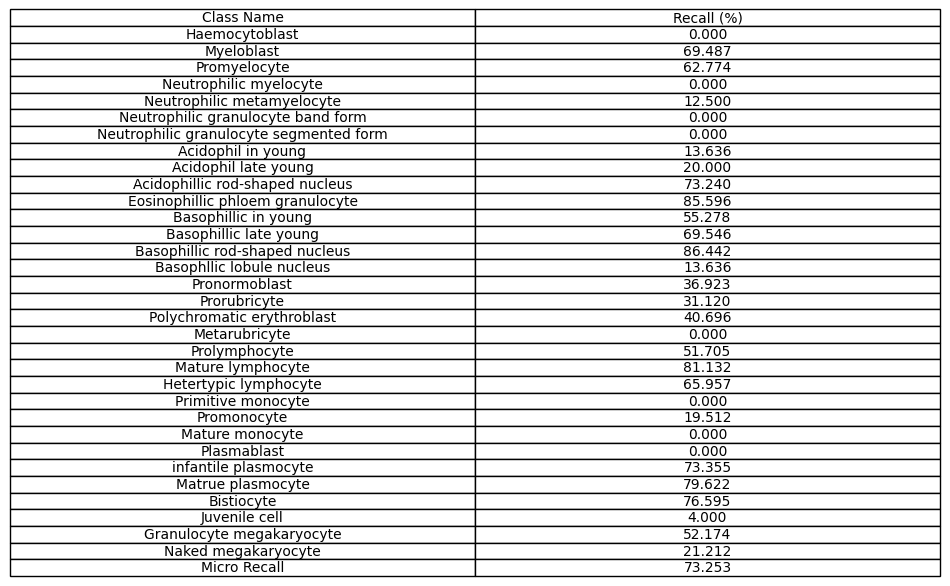

In [15]:
Recall = np.empty((num_class+2, 2), dtype=object)  # 创建一个空的二维数组，用于存储召回率数据，第一列存储类别名称，第二列存储召回率值
Recall[0,0] = 'Class Name'
Recall[0,1] = 'Recall (%)'
Recall[num_class+1,0] = 'Micro Recall'
TP_sum = 0
TP_FN_sum = 0
for idx in range(num_class):
    TP = True_Positive(all_labels, all_preds, idx)
    FN = False_Negative(all_labels, all_preds, idx)
    if TP + FN == 0:
        rec = 0
    else:
        rec = TP / (TP + FN) * 100
        TP_sum += TP
        TP_FN_sum += (TP + FN)
    Recall[idx+1,0] = dataload_five_flower.data_name_dic[idx]
    Recall[idx+1,1] = f"{rec:.3f}"
Recall[num_class+1,1] = f"{TP_sum/TP_FN_sum*100:.3f}" 

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
tb2 = ax.table(cellText=Recall, loc='center', cellLoc='center')
plt.show()

73877 images were found in the dataset.
展示验证集前5张裁剪前后对比图片：


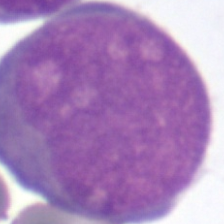

裁剪过的图像尺寸为(224, 224)，对应的标签为：0


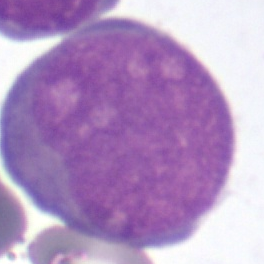

原始图像尺寸为(264, 264)，对应的标签为：0


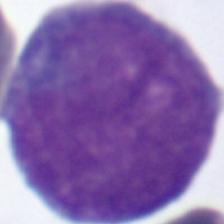

裁剪过的图像尺寸为(224, 224)，对应的标签为：1


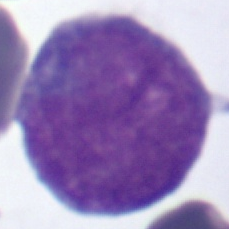

原始图像尺寸为(229, 229)，对应的标签为：1


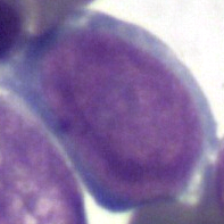

裁剪过的图像尺寸为(224, 224)，对应的标签为：1


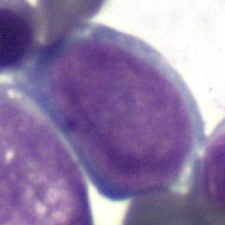

原始图像尺寸为(225, 225)，对应的标签为：1


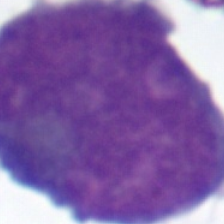

裁剪过的图像尺寸为(224, 224)，对应的标签为：1


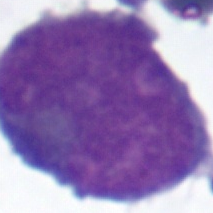

原始图像尺寸为(213, 213)，对应的标签为：1


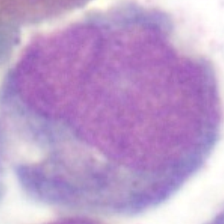

裁剪过的图像尺寸为(224, 224)，对应的标签为：1


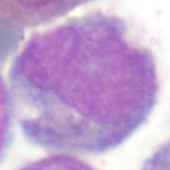

原始图像尺寸为(170, 170)，对应的标签为：1
展示训练集前5张裁剪前后对比图片：


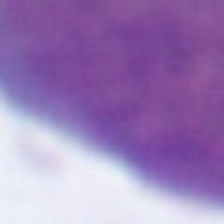

裁剪过的图像尺寸为(224, 224)，对应的标签为：0


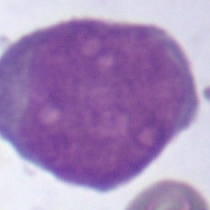

原始图像尺寸为(210, 210)，对应的标签为：0


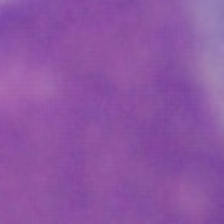

裁剪过的图像尺寸为(224, 224)，对应的标签为：0


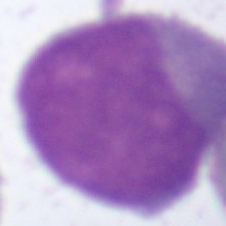

原始图像尺寸为(226, 226)，对应的标签为：0


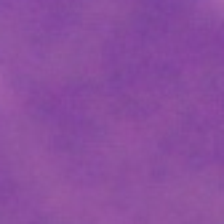

裁剪过的图像尺寸为(224, 224)，对应的标签为：0


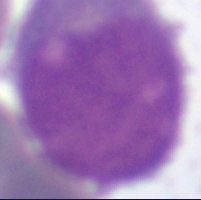

原始图像尺寸为(201, 200)，对应的标签为：0


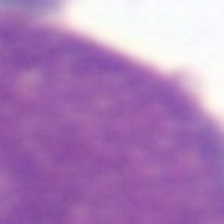

裁剪过的图像尺寸为(224, 224)，对应的标签为：0


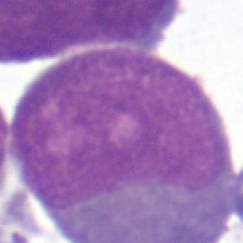

原始图像尺寸为(243, 243)，对应的标签为：0


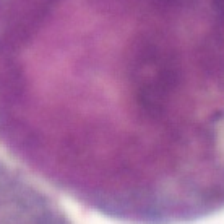

裁剪过的图像尺寸为(224, 224)，对应的标签为：1


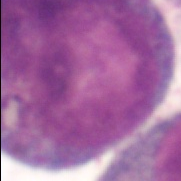

原始图像尺寸为(181, 181)，对应的标签为：1


In [16]:
from torchvision.transforms import ToPILImage

train_dataset = dataload_five_flower.Five_Flowers_Load(
    os.path.join(data_path, 'train'), transform=data_transform["train"])


def tensor_to_PIL(img_tensor, mean, std):
       # img_tensor: torch.Tensor, shape (C,H,W) or (B,C,H,W)
    if img_tensor.ndim == 4:
            img_tensor = img_tensor[0]
    img = img_tensor.cpu().clone()
        # 反归一化： img = img * std + mean
    mean = torch.tensor(mean).view(-1, 1,1)
    std = torch.tensor(std).view(-1, 1,1)
    img = img * std + mean
    img = img.clamp(0, 1)
    return ToPILImage()(img)


# 读取前面5张val验证集图片进行展示
print("展示验证集前5张裁剪前后对比图片：")
for i in range(5):
    img, label = val_dataset.__getitem__(i)
    imgorig, labelorig = val_dataset.__getitemorig__(i)
    pil_img = tensor_to_PIL(img, mean=[0.485, 0.456,0.406], std=[0.229,0.224,0.225])
    display(pil_img)
    print(f"裁剪过的图像尺寸为{pil_img.size}，对应的标签为：{label}")
    display(imgorig)
    print(f"原始图像尺寸为{imgorig.size}，对应的标签为：{labelorig}")

# 读取前面5张train验证集图片进行展示
print("展示训练集前5张裁剪前后对比图片：")
for i in range(5):
    img, label = train_dataset.__getitem__(i)
    imgorig, labelorig = train_dataset.__getitemorig__(i)
    pil_img = tensor_to_PIL(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    display(pil_img)
    print(f"裁剪过的图像尺寸为{pil_img.size}，对应的标签为：{label}")
    display(imgorig)
    print(f"原始图像尺寸为{imgorig.size}，对应的标签为：{labelorig}")